In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import requests
import zipfile
import glob
import matplotlib.pyplot as plt

from parse_reference_spectra import parse_gnps_json, output_loop
from spectra_to_sirius import master_loop
from clone_ds_to_beta import copy_beta
from results_from_metaspace_msms_process import logon_metaspace
from metaspace.sm_annotation_utils import SMInstance
from results_from_metaspace_msms_process import split_data_frame_list
from sirius_to_metaspace_db import primary_loop
from cosine_spectra import score_alignment, read_ms_file
from metaspace_msms_mirror_spectra import mirror_main

Workflow steps on spotted standards for METASAPCE MS/MS publication.

"not now" are slow steps that should work, but are slow, not worth executing every time.

https://github.com/DinosaurInSpace/metaspace_msms_paper/blob/master/README.md
I. Steps 1-12

Next steps:
1. Export spotted MSMS databases +/-, have Lachlan search with existing data.
2. Combine previous cm3 with (1), avoiding repitition etc (semi-manual may be best?)
3. Use to make custom database for Lachlan

In [3]:
# 1. Authentic standard compounds of interest (COI's).
spotted_cmpds_df = pd.read_csv('input/spotted_cmpds.csv', sep="\t").iloc[:,1:].copy(deep=True)

In [4]:
# 2. Downloading database references: GNPS
# Academic users only: contact "ccms-web@cs.ucsd.edu" and request "gnps_exp_all.json"
# Copy to "intermediate/gnps_exp_all.json"
gnps_df = parse_gnps_json('intermediate/gnps_exp_all.json')
gnps_df.to_pickle('intermediate/gnps_df.pickle')

In [ ]:
### not now ###
# 2. Downloading database references: HMDB 
with open('intermediate/hmdb_experimental_msms_spectra.zip', 'wb') as f:
    f.write(requests.get('http://specdb.wishartlab.com/downloads/exports/spectra_xml/hmdb_experimental_msms_spectra.zip', allow_redirects=True).content)
with zipfile.ZipFile('intermediate/hmdb_experimental_msms_spectra.zip', 'r') as z:
    z.extractall('intermediate/hmdb_lcms/hmdb_experimental_msms_spectra/')
    
with open('intermediate/hmdb_predicted_msms_spectra.zip', 'wb') as f:
    f.write(requests.get('http://specdb.wishartlab.com/downloads/exports/spectra_xml/hmdb_predicted_msms_spectra.zip', allow_redirects=True).content)
with zipfile.ZipFile('intermediate/hmdb_predicted_msms_spectra.zip', 'r') as z:
    z.extractall('intermediate/hmdb_lcms/hmdb_predicted_msms_spectra/')

!python hmdb_parser.py --input intermediate/hmdb_lcms/ --output intermediate/databases/ --polarity both

In [ ]:
### not now ###
# 2. Downloading database references: MONA
!python query_mona.py --input input/core_metabolome_v3.pickle --output intermediate/databases/ --polarity negative
!python query_mona.py --input input/core_metabolome_v3.pickle --output intermediate/databases/ --polarity positive

In [7]:
# 3. Collecting predicted MS/MS spectra for spotted compounds
# ref_theo_pos = 'input/reference_spectra/positive_theoretical'
# ref_theo_neg = 'input/reference_spectra/negative_theoretical'

In [8]:
# 4. Collecting reference experimental MS/MS spectra for spotted compounds
# ref_expt_pos = 'input/reference_spectra/positive_experimental'
# ref_expt_neg = 'input/reference_spectra/negative_experimental'

## Metadata: except for those mentioned by Mans, all are +, M + H+, DHB

In [11]:
# 5. Collecting in-house experimental MS/MS spectra for spotted compounds
ref_exptl_embl_pos = pd.read_pickle("input/reference_spectra/spotted_ref_exptl_df.pickle")

In [12]:
# Converted fiole, may need to double check header compatiability with "gnps_df.pickle"
ref_exptl_embl_pos

,Compound_Name,spectrum_id,peaks_json,Adduct,Smiles,Ion_Mode,library_membership,INCHI,can_smiles
0,LysoPC(15:0),HMDB0010381,"[[50.1694,16485.18],[56.0495,69933.74],[57.033...",M+H,CCCCCCCCCCCCCCC(=O)OCC(O)COP(=O)([O-])OCC[N+](...,positive,EMBL_LCMS,InChI=1S/C23H48NO7P/c1-5-6-7-8-9-10-11-12-13-1...,CCCCCCCCCCCCCCC(=O)OCC(O)COP(=O)([O-])OCC[N+](...
1,LysoPC(15:0),HMDB0010381,"[[50.17822071,1157.8873786926],[50.40431444,89...",M+H,CCCCCCCCCCCCCCC(=O)OCC(O)COP(=O)([O-])OCC[N+](...,positive,EMBL_MALDI,InChI=1S/C23H48NO7P/c1-5-6-7-8-9-10-11-12-13-1...,CCCCCCCCCCCCCCC(=O)OCC(O)COP(=O)([O-])OCC[N+](...
2,N-acetylserine,HMDB0002931,"[[51.5324,2190.55],[52.2057,2017.19],[60.0444,...",M+H,CC(O)=NC(CO)C(=O)O,positive,EMBL_LCMS,"InChI=1S/C5H9NO4/c1-3(8)6-4(2-7)5(9)10/h4,7H,2...",CC(O)=NC(CO)C(=O)O
3,N-acetylserine,HMDB0002931,"[[50.15420004,966.9734554291],[50.58650696,835...",M+H,CC(O)=NC(CO)C(=O)O,positive,EMBL_MALDI,"InChI=1S/C5H9NO4/c1-3(8)6-4(2-7)5(9)10/h4,7H,2...",CC(O)=NC(CO)C(=O)O
4,Palmitoylethanolamide,HMDB0002100,"[[55.0542,8673.61],[57.0699,67834.48],[62.0600...",M+H,CCCCCCCCCCCCCCCC(O)=NCCO,positive,EMBL_LCMS,InChI=1S/C18H37NO2/c1-2-3-4-5-6-7-8-9-10-11-12...,CCCCCCCCCCCCCCCC(O)=NCCO
5,Palmitoylethanolamide,HMDB0002100,"[[50.00779023,848.6955986023],[50.3285969,1191...",M+H,CCCCCCCCCCCCCCCC(O)=NCCO,positive,EMBL_MALDI,InChI=1S/C18H37NO2/c1-2-3-4-5-6-7-8-9-10-11-12...,CCCCCCCCCCCCCCCC(O)=NCCO
6,Taurochenodeoxycholic acid,HMDB0000951,"[[50.9296,2529.56],[58.6370,2381.43],[59.5176,...",M+H,CC(CCC(O)=NCCS(=O)(=O)O)C1CCC2C3C(O)CC4CC(O)CC...,positive,EMBL_LCMS,InChI=1S/C26H45NO6S/c1-16(4-7-23(30)27-12-13-3...,CC(CCC(O)=NCCS(=O)(=O)O)C1CCC2C3C(O)CC4CC(O)CC...
7,Taurochenodeoxycholic acid,HMDB0000951,"[[50.52382133,902.4640445709],[50.92414125,972...",M+H,CC(CCC(O)=NCCS(=O)(=O)O)C1CCC2C3C(O)CC4CC(O)CC...,positive,EMBL_MALDI,InChI=1S/C26H45NO6S/c1-16(4-7-23(30)27-12-13-3...,CC(CCC(O)=NCCS(=O)(=O)O)C1CCC2C3C(O)CC4CC(O)CC...
8,Taurodeoxycholic acid,HMDB0000896,"[[51.1689,2816.81],[55.0542,17792.92],[66.8493...",M+H,CC(CCC(O)=NCCS(=O)(=O)O)C1CCC2C3CCC4CC(O)CCC4(...,positive,EMBL_LCMS,InChI=1S/C26H45NO6S/c1-16(4-9-24(30)27-12-13-3...,CC(CCC(O)=NCCS(=O)(=O)O)C1CCC2C3CCC4CC(O)CCC4(...
9,Taurodeoxycholic acid,HMDB0000896,"[[50.37295395,1076.061750412],[50.5072592,1050...",M+H,CC(CCC(O)=NCCS(=O)(=O)O)C1CCC2C3CCC4CC(O)CCC4(...,positive,EMBL_MALDI,InChI=1S/C26H45NO6S/c1-16(4-9-24(30)27-12-13-3...,CC(CCC(O)=NCCS(=O)(=O)O)C1CCC2C3CCC4CC(O)CCC4(...


In [54]:
# 6. Generating custom MS1 database using known spotted compounds.
cm3_df = pd.read_pickle('input/core_metabolome_v3.pickle')
cm3_stds_df = cm3_df[cm3_df.id.isin(list(spotted_cmpds_df.id))].copy(deep=True)
cm3_stds_df.to_pickle("I_spotted_standards/cm3_stds_df.pickle")

In [5]:
# Captures all databases ran
spotted_ds_id_in = {"2020-08-03_08h05m09s": ['positive', 'DHB', 'AIF_off', 'cm3_stds_df2'],
                    "2020-08-03_19h30m50s": ['positive', 'DHB', 'AIF_on', 'cm3_stds_df2'],
                    "2020-08-06_22h56m24s": ['negative', 'DAN', 'AIF_off', 'cm3_stds_df2'],
                    "2020-08-07_15h35m37s": ['negative', 'DAN', 'AIF_on', 'cm3_stds_df2']}

# Wrong-way matrix/ionization
spotted_df_not_used = {"2020-08-07_15h01m22s": ['positive', 'DAN', 'AIF_off', 'cm3_stds_df2'],
                       "2020-08-07_23h24m28s": ['positive', 'DAN', 'AIF_on', 'cm3_stds_df2'],
                       "2020-08-04_01h47m02s": ['negative', 'DHB', 'AIF_off', 'cm3_stds_df2'],
                       "2020-08-04_09h59m07s": ['negative', 'DHB', 'AIF_on', 'cm3_stds_df2']}

In [14]:
# Don't rerun!  Will clone datasets
# 7. Running and interpreting the METASPACE results.
out_dict_list = []
for ds, meta in spotted_ds_id_in.items():
    if meta[0] == 'positive':
        x = copy_beta(ds, 'HNaKM', meta[3])
    elif meta[0] == 'negative':
        x = copy_beta(ds, 'HM', meta[3])
    out_dict_list.append(x)
    
out_df = pd.DataFrame(out_dict_list)
out_df.to_pickle('cm3_spotted_ms_df.pickle')

{'ds_id_in': '2020-08-03_08h05m09s', 'ds_id_out': '2020-08-23_23h01m56s'}
{'ds_id_in': '2020-08-03_19h30m50s', 'ds_id_out': '2020-08-23_23h02m01s'}
{'ds_id_in': '2020-08-06_22h56m24s', 'ds_id_out': '2020-08-23_23h02m04s'}
{'ds_id_in': '2020-08-07_15h35m37s', 'ds_id_out': '2020-08-23_23h02m08s'}


In [7]:
out_df = pd.read_pickle('cm3_spotted_ms_df.pickle')

In [57]:
out_df

,ds_id_in,ds_id_out
0,2020-08-03_08h05m09s,2020-08-23_23h01m56s
1,2020-08-03_19h30m50s,2020-08-23_23h02m01s
2,2020-08-06_22h56m24s,2020-08-23_23h02m04s
3,2020-08-07_15h35m37s,2020-08-23_23h02m08s


In [8]:
# 7. Running and interpreting the METASPACE results.
df_list = []
for ms_ds_id in out_df.ds_id_out:
    ds_id_in = list(out_df[out_df.ds_id_out == ms_ds_id].ds_id_in)[0]
    sm = SMInstance(host='https://beta.metaspace2020.eu')
    sm = logon_metaspace(sm)
    ds = sm.dataset(id=ms_ds_id)
    results_df = ds.results(database='cm3_stds_df2').reset_index()
    results_df['ds_id_in'] = ds_id_in
    df_list.append(results_df)

ms1_df = pd.concat(df_list)
ms1_df = ms1_df[ms1_df.fdr <=0.5]
ms1_df = ms1_df[['ds_id_in', 'moleculeIds']]
ms1_df = split_data_frame_list(ms1_df, 'moleculeIds')

## Plot MS1 figures here for standards to folder.

In [9]:
# What do I do with this file?  Use for plotting?
ms1_df

,ds_id_in,moleculeIds
0,2020-08-03_08h05m09s,HMDB0001256
1,2020-08-03_08h05m09s,HMDB0000201
2,2020-08-03_08h05m09s,HMDB0000517
3,2020-08-03_08h05m09s,HMDB0000034
4,2020-08-03_08h05m09s,HMDB0000086
...,...,...
302,2020-08-07_15h35m37s,HMDB0000244
303,2020-08-07_15h35m37s,HMDB0003333
304,2020-08-07_15h35m37s,HMDB0000133
305,2020-08-07_15h35m37s,HMDB0000030


In [47]:
# 8. Generating custom MS2 database using known spotted compounds.
gnps_exp_all = 'intermediate/gnps_exp_all.json'
hmdb_exp_negative = 'intermediate/hmdb_exp_negative.pickle'
hmdb_exp_positive = 'intermediate/hmdb_exp_positive.pickle'
hmdb_theo_negative = 'intermediate/hmdb_theo_negative.pickle'
hmdb_theo_positive = 'intermediate/hmdb_theo_positive.pickle'
mona_exp_negative = 'intermediate/mona_exp_negative.pickle'
mona_exp_positive = 'intermediate/mona_exp_positive.pickle'
ref_exptl_embl_pos = 'input/reference_spectra/spotted_ref_exptl_df.pickle'

# Generate reference database limited to cmpds with theo/exp spectra
output_loop("I_spotted_standards/cm3_stds_df.pickle",
            'intermediate/',
            gnps_exp_all,
            hmdb_exp_positive,
            hmdb_exp_negative,
            hmdb_theo_positive,
            hmdb_theo_negative,
            mona_exp_positive,
            mona_exp_negative,
            ref_exptl_embl_pos
           )

I_spotted_standards/cm3_stds_df.pickle
here
517
gnps_hits_df:  (517, 9)
hmdb_exptl_df:  (1929, 5)
hmdb_theo_df:  (435812, 5)
mona_hits_df:  (5650, 15)
intermediate/ref_expt_df.pickle   (48, 7)
intermediate/ref_theo_df.pickle   (1, 7)
Parse_reference_spectra.py executed successfully!


1

In [48]:
# Parses spectra from databases and runs Sirius
# Manually delete contents of "trees", "spectra_positive", 
# and "spectra_negative" before running each time!
master_loop('intermediate/ref_expt_df.pickle',
            'intermediate/sirius_out/',
            'intermediate/gnps_df.pickle',
            hmdb_exp_positive,
            hmdb_exp_negative,
            hmdb_theo_positive,
            hmdb_theo_negative,
            mona_exp_positive,
            mona_exp_negative,
            'positive',
            'exp'
           )

master_loop('intermediate/ref_expt_df.pickle',
            'intermediate/sirius_out/',
            'intermediate/gnps_df.pickle',
            hmdb_exp_positive,
            hmdb_exp_negative,
            hmdb_theo_positive,
            hmdb_theo_negative,
            mona_exp_positive,
            mona_exp_negative,
            'negative',
            'exp'
           )

master_loop('intermediate/ref_theo_df.pickle',
            'intermediate/sirius_out/',
            'intermediate/gnps_df.pickle',
            hmdb_exp_positive,
            hmdb_exp_negative,
            hmdb_theo_positive,
            hmdb_theo_negative,
            mona_exp_positive,
            mona_exp_negative,
            'positive',
            'theo'
           )

master_loop('intermediate/ref_theo_df.pickle',
            'intermediate/sirius_out/',
            'intermediate/gnps_df.pickle',
            hmdb_exp_positive,
            hmdb_exp_negative,
            hmdb_theo_positive,
            hmdb_theo_negative,
            mona_exp_positive,
            mona_exp_negative,
            'negative',
            'theo'
           )


 series 0 0_HMDB0000630_Cytosine
0   M+H
m_df: 0 g_df 1 e_df 8 t_df 0

 series 1 1_HMDB0000562_Creatinine
1   M+Na
m_df: 0 g_df 3 e_df 0 t_df 0
1   M+K
m_df: 0 g_df 3 e_df 0 t_df 0
1   M+H
m_df: 0 g_df 4 e_df 1 t_df 0

 series 2 2_HMDB0000883_LValine
2   M+Na
m_df: 0 g_df 1 e_df 0 t_df 0
2   M+H
m_df: 0 g_df 35 e_df 10 t_df 0

 series 3 3_HMDB0003355_5Aminopentanoic_acid
3   M+Na
m_df: 0 g_df 1 e_df 0 t_df 0
3   M+H
m_df: 0 g_df 6 e_df 1 t_df 0

 series 4 4_HMDB0000043_Betaine
4   M+Na
m_df: 0 g_df 1 e_df 0 t_df 0
4   M+H
m_df: 0 g_df 7 e_df 2 t_df 0

 series 5 5_HMDB0000251_Taurine
5   M+Na
m_df: 0 g_df 1 e_df 0 t_df 0
5   M+H
m_df: 0 g_df 10 e_df 9 t_df 0

 series 6 6_HMDB0000064_Creatine
6   M+Na
m_df: 0 g_df 1 e_df 0 t_df 0
6   M+H
m_df: 0 g_df 11 e_df 9 t_df 0

 series 7 7_HMDB0013222_BetaGuanidinopropionic_acid
7   M+H
m_df: 0 g_df 2 e_df 0 t_df 0

 series 8 8_HMDB0000034_Adenine
8   M+Na
m_df: 0 g_df 3 e_df 0 t_df 0
8   M+K
m_df: 0 g_df 3 e_df 0 t_df 0
8   M+H
m_df: 0 g_df 4 e_


 series 0 0_HMDB0000630_Cytosine

 series 1 1_HMDB0000562_Creatinine
1   M-H
m_df: 0 g_df 3 e_df 0 t_df 0

 series 2 2_HMDB0000883_LValine
2   M-H
m_df: 0 g_df 1 e_df 1 t_df 0

 series 3 3_HMDB0003355_5Aminopentanoic_acid
3   M-H
m_df: 0 g_df 0 e_df 1 t_df 0

 series 4 4_HMDB0000043_Betaine

 series 5 5_HMDB0000251_Taurine
5   M-H
m_df: 0 g_df 1 e_df 8 t_df 0

 series 6 6_HMDB0000064_Creatine
6   M-H
m_df: 0 g_df 2 e_df 9 t_df 0

 series 7 7_HMDB0013222_BetaGuanidinopropionic_acid

 series 8 8_HMDB0000034_Adenine
8   M-H
m_df: 0 g_df 3 e_df 3 t_df 0

 series 9 9_HMDB0001257_Spermidine

 series 10 10_HMDB0006899_Alanylglycine

 series 11 11_HMDB0000641_LGlutamine
11   M-H
m_df: 0 g_df 6 e_df 8 t_df 0

 series 12 12_HMDB0002031_Ureidoisobutyric_acid

 series 13 13_HMDB0002931_NAcetylserine

 series 14 14_HMDB0000148_LGlutamic_acid
14   M-H
m_df: 0 g_df 1 e_df 9 t_df 0

 series 15 15_HMDB0000517_LArginine
15   M-H
m_df: 0 g_df 0 e_df 10 t_df 0

 series 16 16_HMDB0000158_LTyrosine
16   M-

1

In [ ]:
# Sirius out:  intermediate/sirius_out/exp_positive.pickle (46, 2)
# Sirius out:  intermediate/sirius_out/exp_negative.pickle (25, 2)
# Sirius out:  intermediate/sirius_out/theo_positive.pickle (1, 2)
# Sirius out:  intermediate/sirius_out/theo_negative.pickle (1, 2)

In [49]:
# 8. Generating custom MS2 database using known spotted compounds.
# Won't overwrite?  Delete output files if rerunning same job!
for ds, meta in spotted_ds_id_in.items():
    print(ds, meta)
    #primary_loop(list(cm3_stds_df.name.unique()),
    primary_loop([],
                 ds,
                 'I_spotted_standards/db_out/',
                 meta[0],
                 'intermediate/sirius_out/exp_positive.pickle',
                 'intermediate/sirius_out/theo_positive.pickle',
                 'intermediate/sirius_out/exp_negative.pickle',
                 'intermediate/sirius_out/theo_negative.pickle',
                 'intermediate/ref_expt_df.pickle',
                 'intermediate/ref_theo_df.pickle'
                 )

2020-08-03_08h05m09s ['positive', 'DHB', 'AIF_off', 'cm3_stds_df2']
2 (552, 15) 1    552
Name: dmass, dtype: int64
3 (552, 15)
Observed ions: 
 1    552
Name: dmass, dtype: int64
4 (552, 15)
Correct ionformulas: 
 True    552
Name: good_mass_calc, dtype: int64
I_spotted_standards/db_out/2020-08-03_08h05m09s.csv
2020-08-03_19h30m50s ['positive', 'DHB', 'AIF_on', 'cm3_stds_df2']
2 (552, 15) 1    552
Name: dmass, dtype: int64
3 (552, 15)
Observed ions: 
 1    552
Name: dmass, dtype: int64
4 (552, 15)
Correct ionformulas: 
 True    552
Name: good_mass_calc, dtype: int64
I_spotted_standards/db_out/2020-08-03_19h30m50s.csv
2020-08-06_22h56m24s ['negative', 'DAN', 'AIF_off', 'cm3_stds_df2']
2 (344, 15) -1    344
Name: dmass, dtype: int64
3 (344, 15)
Observed ions: 
 -1    344
Name: dmass, dtype: int64
4 (344, 15)
Error! No  H  to increment by  -1  in X!
Error! No  H  to increment by  -1  in X!
Error! No  H  to increment by  -1  in X!
Correct ionformulas: 
 True    341
Name: good_mass_calc, dt

In [54]:
# 47 positive mode
# 26 negative mode
dfs_out = ['I_spotted_standards/db_out/2020-08-03_08h05m09s.csv',
           'I_spotted_standards/db_out/2020-08-03_19h30m50s.csv',
           'I_spotted_standards/db_out/2020-08-06_22h56m24s.csv',
           'I_spotted_standards/db_out/2020-08-07_15h35m37s.csv']

dummy_df = pd.read_csv(dfs_out[3], sep="\t")
dummy_df['n'] = dummy_df.id.apply(lambda x: x.split("_")[0])
len(list(dummy_df.n.value_counts()))

26

Okay, everything is finally running!
1. Insert additional spectra from experimental authentic standards
2. Use code below to bring in cm3_msms and save time (e.g. LC)

In [41]:
### Faster, now ###
# 8. Generating custom MS2 database using known spotted compounds.
# Load complete databases in positive and negative mode, then filter for spotted compounds.

cm3_stds_list = list(pd.read_csv("cm3_stds_df.csv", sep="\t").id)

# Positive
cm3_msms_all_pos_df = pd.read_csv("I_spotted_standards/cm3_msms_all_pos.csv", sep="\t")
cm3_msms_all_pos_df['id_temp'] = cm3_msms_all_pos_df['id'].apply(lambda x: x.split("_")[0]) 
cm3_msms_all_pos_df = cm3_msms_all_pos_df[cm3_msms_all_pos_df.id_temp.isin(cm3_stds_list)].iloc[:,1:-1]
cm3_msms_all_pos_df.to_csv("I_spotted_standards/cm3_msms_stds_pos_df", sep="\t")

# Negative
cm3_msms_all_neg_df = pd.read_csv("I_spotted_standards/cm3_msms_all_neg.csv", sep="\t")
cm3_msms_all_neg_df['id_temp'] = cm3_msms_all_neg_df['id'].apply(lambda x: x.split("_")[0]) 
cm3_msms_all_neg_df = cm3_msms_all_neg_df[cm3_msms_all_neg_df.id_temp.isin(cm3_stds_list)].iloc[:,1:-1]
cm3_msms_all_neg_df.to_csv("I_spotted_standards/cm3_msms_stds_neg_df", sep="\t")

In [21]:
### Don't run until database is updated!
# 9. Running and interpreting the METASPACE MSMS results.
out_dict_list = []
for ds, meta in spotted_ds_id_in.items():
    if meta[0] == 'positive':
        x = copy_beta(ds, 'M', 'cm3_msms_stds_pos_df')
    elif meta[0] == 'negative':
        x = copy_beta(ds, 'M', 'cm3_msms_stds_pos_df')
    out_dict_list.append(x)
    
out_df2 = pd.DataFrame(out_dict_list)
out_df2.to_pickle('cm3_spotted_msms_df.pickle')

{'ds_id_in': '2020-08-03_08h05m09s', 'ds_id_out': '2020-08-24_00h23m54s'}
{'ds_id_in': '2020-08-03_19h30m50s', 'ds_id_out': '2020-08-24_00h23m59s'}
{'ds_id_in': '2020-08-06_22h56m24s', 'ds_id_out': '2020-08-24_00h24m04s'}
{'ds_id_in': '2020-08-07_15h35m37s', 'ds_id_out': '2020-08-24_00h24m09s'}


In [ ]:
## Check data manually off-line
## Compare reference versus spot spectra verus +AIF spectra
## Repeat with Psuedo spectra (just showing expected peaks)

In [ ]:
# 10. Generate psuedo-MS/MS spectra from ISF data.


In [ ]:
# Test inputs, replace with actual data when available.
original_ds_id_on_prod = '2020-03-12_17h55m21s'  # Update to run!
db_id_on_beta = '2020-05-13_17h50m21s'  # Update to run!
ds_id_on_beta = '2020-05-14_16h32m01s'  # Update to run!
path_to_reports = 'TEMP/reporting/'  # Update to run!
polarity = ['positive', 'negative'][0]  # Update to run!
psuedo_y_axis = ['binary', 'fdr', 'msm', 'cos', 'intensity'][0]
ref_spectra_df = pd.read_pickle("input/cm3_reference_spectra_df.pickle")

In [ ]:
# Real inputs as databecomes available
original_ds_id_on_prod = None  # Update to run!
db_id_on_beta = None  # Update to run!
ds_id_on_beta = None  # Update to run!
path_to_reports = 'TEMP/reporting/'  # Update to run!
polarity = ['positive', 'negative'][0]  # Update to run!
psuedo_y_axis = ['binary', 'fdr', 'msm', 'cos', 'intensity'][0]
ref_spectra_df = pd.read_pickle("input/cm3_reference_spectra_df.pickle")
x = list(spotted_cmpds_df.id)
ref_spectra_df = ref_spectra_df[ref_spectra_df.id.isin(x)]

2020-05-14_16h32m01s  Counter:  11
1   2020-05-14_16h32m01s


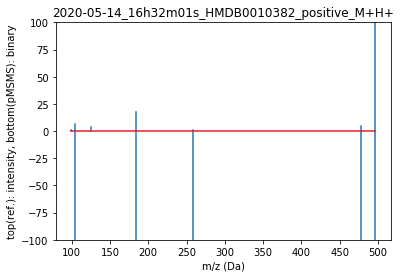

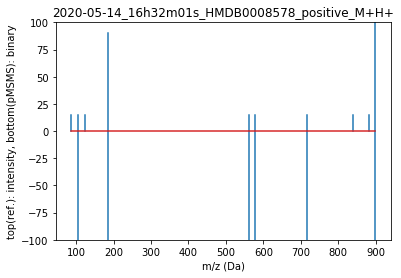

0    (Figure(432x288), AxesSubplot(0.125,0.125;0.77...
1    (Figure(432x288), AxesSubplot(0.125,0.125;0.77...
dtype: object

In [12]:
mirror_main(original_ds_id_on_prod,
                db_id_on_beta,
                ds_id_on_beta,
                path_to_reports,
                polarity,
                psuedo_y_axis,
                ref_spectra_df)

In [13]:
# 11. Compare predicted, experimental, and psuedo-MS/MS spectra.
# Manually review in directory below to pick winners
path_to_reports

'TEMP/reporting/'

In [ ]:
# 12. Pick winners and carry well-behaved molecules forward.
hits = []
well_behaved_hits = cm3_stds_df[cm3_stds_df.id.isin(hits)].copy(deep=True)
well_behaved_hits.to_pickle('intermediate/val_spotted.pickle')